### imports

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle



### load training and testing sets

In [2]:
#if loaded train file exists
try:
    with open('data/train-data.pickle', 'rb') as handle:
        train = pickle.load(handle)
#if not load and save
except:
    !unzip data/training_set_VU_DM.csv.zip
    train = pd.read_csv('training_set_VU_DM.csv')
    !rm training_set_VU_DM.csv
    with open('data/train-data.pickle', 'wb') as handle:
        pickle.dump(train, handle)

#if loaded test file exists
try:
    with open('data/test-data.pickle', 'rb') as handle:
        test = pickle.load(handle)
#if not load and save
except:
    !unzip data/test_set_VU_DM.csv.zip
    test = pd.read_csv('test_set_VU_DM.csv')
    !rm test_set_VU_DM.csv
    with open('data/test-data.pickle', 'wb') as handle:
        pickle.dump(test, handle)

### Total columns

In [3]:
train_amount = len(train)
print(f'train length: {train_amount}')
print(f'test length: {len(test)}')
mask = train['booking_bool']==True
booked_amount = len(train[mask])
print(f'booked amount: {booked_amount}')
mask = (train['booking_bool']==False) & (train['click_bool']==True)
clicked_amount = len(train[mask])
print(f'clicked but not booked: {clicked_amount}')
print(f'total/booked: {train_amount/booked_amount}')


train length: 4958347
test length: 4959183
booked amount: 138390
clicked but not booked: 83489
total/booked: 35.82879543319604


### Total null columns

In [4]:
print(train.isnull().sum())


srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

### Amount of hotels in data sets

In [5]:
x = test['prop_id']
print(f'Amount of hotels in test data {len(set(x))} ')
y = train['prop_id']
print(f'Amount of hotels in train data {len(set(y))}')
print(f'Amount of unique hotels in train and not in test {len(set(x) - set(y))}')


Amount of hotels in test data 129438 
Amount of hotels in train data 129113
Amount of unique hotels in train and not in test 7773


### price distribution

Text(10.049999999999997, 0.5, 'count')

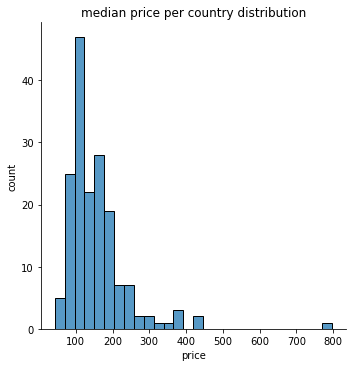

In [6]:
price_per_country_median = train.groupby('prop_country_id').median().reset_index()
price_per_country_median = price_per_country_median[['prop_country_id','price_usd']]
price_per_country_median = price_per_country_median.rename(columns={"price_usd": "price_per_country_median"})
ax = sns.displot(data = price_per_country_median, x='price_per_country_median')
plt.title('median price per country distribution')
plt.xlabel('price')
plt.ylabel('count')

2871


,price_usd
11422,14196.00
11423,17812.00
11424,12447.00
11425,13392.00
11426,17410.00
...,...
4930760,5328.00
4930761,8610.00
4930764,5166.00
4930773,8556.00


/home/wolfson/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:8823: RuntimeWarning: divide by zero encountered in log2
  return lib.map_infer(x.astype(object)._values, func, ignore_na=ignore_na)


0.0


Text(19.474999999999994, 0.5, 'count')

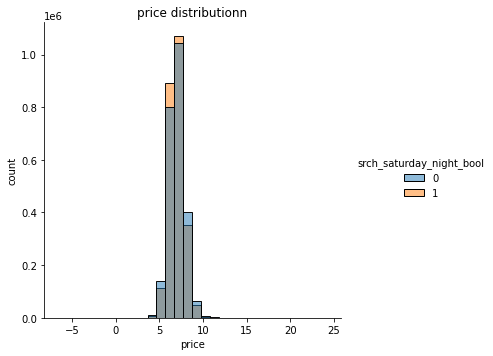

In [7]:
mask = (train['price_usd']>5000)# & (train['booking_bool']==True)
print(len(train.loc[mask]))
display(train.loc[mask, ['price_usd']])
train[['log_price']] = train[['price_usd']].applymap(np.log2)
print(train['price_usd'].min())

ax = sns.displot(data = train, hue="srch_saturday_night_bool", x='log_price', bins=30)

plt.title('price distributionn')
plt.xlabel('price')
plt.ylabel('count')

<AxesSubplot:xlabel='date_time'>

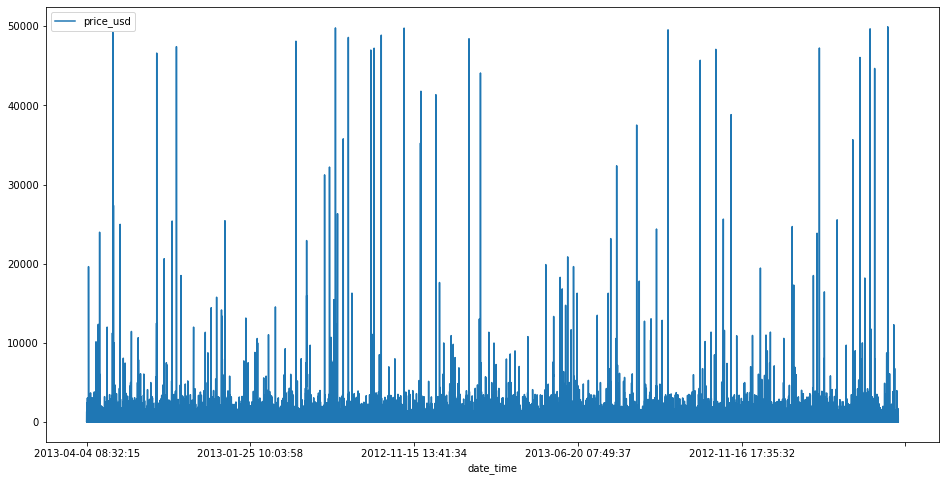

In [8]:
mask = train['price_usd']<50000
train[mask].plot(x = 'date_time', 
        y = 'price_usd', 
        figsize = (16, 8))